In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
# # import shap
# # warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from utils.metrics import evaluate
from utils.plots import bar_metrics

from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.arima_model import ARIMA
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
# from bayes_opt import BayesianOptimization


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

Importing plotly failed. Interactive plots will not work.


2.4.0


In [7]:
raw_col = ['date', 'highest', 'high', 'mid', 'low', 'ave', 'ave_dif', 'volume', 'vol_dif', 'resid']
raw = pd.read_csv('FS443.csv',names=raw_col).drop(['ave_dif', 'vol_dif', 'resid'], axis=1)
for i in range(raw.shape[0]):
    raw.volume[i] = int(raw.volume[i].split(' ')[0].replace(',', ''))
raw.volume = raw.volume.values.astype('int')

ts_date = raw.copy().date
for itr in range(raw.shape[0]):
    date = raw.date[itr].split('/')
    date[0] = str(int(date[0]) + 1911)
    result = '/'.join(date)
    ts_date[itr] =  np.datetime64(datetime.strptime(result, "%Y/%m/%d").date())
    


ts = raw.copy()
ts.date = ts_date
ts['date'] = pd.to_datetime(ts['date'], errors='coerce')
ts = ts.set_index('date')
ts.index = pd.to_datetime(ts.index)
ts

,highest,high,mid,low,ave,volume
date,,,,,,
1998-12-01,195,131,77,59,84.0,327
1998-12-02,165,144,111,93,113.0,456
1998-12-03,204,160,82,65,94.0,432
1998-12-04,189,161,114,80,116.0,583
1998-12-06,181,157,90,55,96.0,1052
...,...,...,...,...,...,...
2020-11-26,201,201,137,67,134.9,97
2020-11-27,170,170,112,52,111.8,176
2020-11-28,171,171,170,152,166.7,81


In [38]:
df = ts.copy()
df['date'] = ts.index
df['hour'] = df['date'].dt.hour.astype(int)
df['dayofweek'] = df['date'].dt.dayofweek.astype(int)
df['quarter'] = df['date'].dt.quarter.astype(int)
df['month'] = df['date'].dt.month.astype(int)
df['year'] = df['date'].dt.year.astype(int)
df['dayofyear'] = df['date'].dt.dayofyear.astype(int)
df['dayofmonth'] = df['date'].dt.day.astype(int)
df['weekofyear'] = df['date'].dt.weekofyear.astype(int)
df = df.drop(['hour','date'], axis=1)

In [4]:
import tensorflow as tf

In [50]:
df.head(10)

,highest,high,mid,low,ave,volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,,
1998-12-01,195,131,77,59,84.0,327,1,4,12,1998,335,1,49
1998-12-02,165,144,111,93,113.0,456,2,4,12,1998,336,2,49
1998-12-03,204,160,82,65,94.0,432,3,4,12,1998,337,3,49
1998-12-04,189,161,114,80,116.0,583,4,4,12,1998,338,4,49
1998-12-06,181,157,90,55,96.0,1052,6,4,12,1998,340,6,49
1998-12-07,184,175,108,67,113.0,566,0,4,12,1998,341,7,50
1998-12-08,195,190,162,121,159.0,538,1,4,12,1998,342,8,50
1998-12-09,195,191,143,82,140.0,615,2,4,12,1998,343,9,50
1998-12-10,191,190,171,133,166.0,307,3,4,12,1998,344,10,50


In [80]:
def window_dataset(ts,df,window_size):
    w = window_size
    
    
    dataset = tf.data.Dataset.from_tensor_slices(df.values)
    dataset = dataset.window(w, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(w))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    target = []
    x_date = []
    for x,y in dataset:

        x_date.append(y.numpy()[0,[6,7,8,9,10,11,12]])
        target.append(y.numpy()[0,4])


    dataset = tf.data.Dataset.from_tensor_slices(ts.values)
    dataset = dataset.window(w, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(w))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    x_ser = []
    for x,y in dataset:
        x_ser.append(x.numpy().ravel())
        
    x = []
    for i in range(len(x_ser)):
        x.append(np.concatenate((x_ser[i], x_date[i]), axis=0))

    return np.array(x), np.array(target)

In [101]:
def window_dataset_nodate(ts,df,window_size):
    w = window_size
    
    
    dataset = tf.data.Dataset.from_tensor_slices(df.values)
    dataset = dataset.window(w, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(w))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    target = []
    x_date = []
    for x,y in dataset:


        target.append(y.numpy()[0,4])


    dataset = tf.data.Dataset.from_tensor_slices(ts.values)
    dataset = dataset.window(w, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(w))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    x_ser = []
    for x,y in dataset:
        x_ser.append(x.numpy().ravel())
        

    return np.array(x_ser), np.array(target)

### Univariate_machine learning window size = 5

In [74]:
dataset = tf.data.Dataset.from_tensor_slices(train.ave.values)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x.numpy())
    train_y.append(y.numpy())


In [75]:
dataset = tf.data.Dataset.from_tensor_slices(ts[-18:].ave) #20 = 14 + (5-1) -> windows size -1
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
test_x = []
test_y = []
for x,y in dataset:
    test_x.append(x.numpy())
    test_y.append(y.numpy())


In [76]:

reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 38.75


In [77]:
reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 39.12


In [78]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 39.12


In [80]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 39.99


In [81]:

lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 40.53


In [82]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 34.22


In [83]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 28.69


### Uni window size =10

In [99]:
dataset = tf.data.Dataset.from_tensor_slices(train.ave.values)
dataset = dataset.window(10, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(10))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x.numpy())
    train_y.append(y.numpy())


In [100]:
dataset = tf.data.Dataset.from_tensor_slices(ts[-23:].ave) #20 = 14 + (5-1) -> windows size -1
dataset = dataset.window(10, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(10))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
test_x = []
test_y = []
for x,y in dataset:
    test_x.append(x.numpy())
    test_y.append(y.numpy())


In [104]:
reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 38.81


In [105]:
reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 38.91


In [106]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 38.92


In [107]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 41.16


In [108]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 39.66


In [109]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.99


In [110]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 28.46


In [ ]:

reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

### Multivariate(only series)

In [119]:
dataset = tf.data.Dataset.from_tensor_slices(train.values)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x.numpy().ravel())
    train_y.append(y.numpy()[0,4])


In [120]:
dataset = tf.data.Dataset.from_tensor_slices(ts[-18:].values)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
test_x = []
test_y = []
for x,y in dataset:
    test_x.append(x.numpy().ravel())
    test_y.append(y.numpy()[0,4])


In [103]:


x_df, y_df = window_dataset_nodate(ts,df,5)
from sklearn.model_selection import cross_val_score

clf = RandomForestRegressor(random_state=0)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('RF RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.BayesianRidge()
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('BayesianRidge RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.Lasso(alpha=0.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('Lasso RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, random_state =42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('XGB RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = lgb.LGBMRegressor(random_state=42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('LGBM RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('SVR RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = KNeighborsRegressor(n_neighbors=2)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('KNN RMSE {}'.format(round(np.sqrt(mse), 2)))

RF RMSE 23.0
BayesianRidge RMSE 23.15
Lasso RMSE 23.15
XGB RMSE 24.8
LGBM RMSE 23.45
SVR RMSE 49.81
KNN RMSE 32.2


In [81]:
x_df, y_df = window_dataset(ts,df,5)
from sklearn.model_selection import cross_val_score

In [92]:
clf = RandomForestRegressor(random_state=0)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 23.0


In [93]:
clf = linear_model.BayesianRidge()
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 23.13


In [94]:
clf = linear_model.Lasso(alpha=0.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 23.12


In [96]:
clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, random_state =42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 24.67


In [97]:
clf = lgb.LGBMRegressor(random_state=42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 23.34


In [98]:
clf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 49.81


In [99]:
clf = KNeighborsRegressor(n_neighbors=2)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 32.88


### Multi window size =10

In [129]:
dataset = tf.data.Dataset.from_tensor_slices(train.values)
dataset = dataset.window(10, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(10))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x.numpy().ravel())
    train_y.append(y.numpy()[0,4])


In [130]:
dataset = tf.data.Dataset.from_tensor_slices(ts[-23:].values)
dataset = dataset.window(10, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(10))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
test_x = []
test_y = []
for x,y in dataset:
    test_x.append(x.numpy().ravel())
    test_y.append(y.numpy()[0,4])


### no date

In [102]:


x_df, y_df = window_dataset_nodate(ts,df,10)
from sklearn.model_selection import cross_val_score

clf = RandomForestRegressor(random_state=0)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('RF RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.BayesianRidge()
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('BayesianRidge RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.Lasso(alpha=0.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('Lasso RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, random_state =42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('XGB RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = lgb.LGBMRegressor(random_state=42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('LGBM RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('SVR RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = KNeighborsRegressor(n_neighbors=2)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('KNN RMSE {}'.format(round(np.sqrt(mse), 2)))

RF RMSE 23.13
BayesianRidge RMSE 23.17
Lasso RMSE 23.19
XGB RMSE 24.61
LGBM RMSE 23.46
SVR RMSE 49.82
KNN RMSE 37.67


### with date

In [100]:
x_df, y_df = window_dataset(ts,df,10)
from sklearn.model_selection import cross_val_score

clf = RandomForestRegressor(random_state=0)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('RF RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.BayesianRidge()
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('BayesianRidge RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.Lasso(alpha=0.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('Lasso RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, random_state =42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('XGB RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = lgb.LGBMRegressor(random_state=42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('LGBM RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('SVR RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = KNeighborsRegressor(n_neighbors=2)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('KNN RMSE {}'.format(round(np.sqrt(mse), 2)))

RF RMSE 23.09
BayesianRidge RMSE 23.16
Lasso RMSE 23.16
XGB RMSE 24.66
LGBM RMSE 23.27
SVR RMSE 49.82
KNN RMSE 37.86


In [134]:
reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30.68


In [135]:
reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 29.47


In [136]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 29.41


In [137]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 36.74


In [138]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30.43


In [139]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.99


In [140]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 27.82


14

### Multi window size to 14

In [143]:
dataset = tf.data.Dataset.from_tensor_slices(train.values)
dataset = dataset.window(14, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(14))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x.numpy().ravel())
    train_y.append(y.numpy()[0,4])


In [144]:
dataset = tf.data.Dataset.from_tensor_slices(ts[-27:].values)
dataset = dataset.window(14, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(14))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
test_x = []
test_y = []
for x,y in dataset:
    test_x.append(x.numpy().ravel())
    test_y.append(y.numpy()[0,4])


### no date

In [104]:


x_df, y_df = window_dataset_nodate(ts,df,14)
from sklearn.model_selection import cross_val_score

clf = RandomForestRegressor(random_state=0)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('RF RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.BayesianRidge()
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('BayesianRidge RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.Lasso(alpha=0.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('Lasso RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, random_state =42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('XGB RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = lgb.LGBMRegressor(random_state=42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('LGBM RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('SVR RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = KNeighborsRegressor(n_neighbors=2)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('KNN RMSE {}'.format(round(np.sqrt(mse), 2)))

RF RMSE 23.15
BayesianRidge RMSE 23.2
Lasso RMSE 23.24
XGB RMSE 25.11
LGBM RMSE 23.3
SVR RMSE 49.83
KNN RMSE 39.13


### with date

In [105]:
x_df, y_df = window_dataset(ts,df,14)
from sklearn.model_selection import cross_val_score

clf = RandomForestRegressor(random_state=0)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('RF RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.BayesianRidge()
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('BayesianRidge RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = linear_model.Lasso(alpha=0.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=10, scoring='neg_mean_squared_error').mean())

print('Lasso RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000, random_state =42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('XGB RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = lgb.LGBMRegressor(random_state=42)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('LGBM RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('SVR RMSE {}'.format(round(np.sqrt(mse), 2)))

clf = KNeighborsRegressor(n_neighbors=2)
mse = -(cross_val_score(clf, x_df, y_df, cv=5, scoring='neg_mean_squared_error').mean())

print('KNN RMSE {}'.format(round(np.sqrt(mse), 2)))

RF RMSE 23.14
BayesianRidge RMSE 23.2
Lasso RMSE 23.22
XGB RMSE 24.63
LGBM RMSE 23.25
SVR RMSE 49.83
KNN RMSE 39.53


In [147]:
reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30.79


In [148]:
reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 29.52


In [149]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 29.29


In [150]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 31.82


In [151]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30.98


In [152]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.99


In [153]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 23.04


### Multi window size = 14 scaler

In [199]:
dataset = tf.data.Dataset.from_tensor_slices(train.values)
dataset = dataset.window(14, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(14))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x.numpy().ravel())
    train_y.append(y.numpy()[0,4])


In [200]:
dataset = tf.data.Dataset.from_tensor_slices(ts[-27:].values)
dataset = dataset.window(14, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(14))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
test_x = []
test_y = []
for x,y in dataset:
    test_x.append(x.numpy().ravel())
    test_y.append(y.numpy()[0,4])


In [201]:
train_y = np.array(train_y).reshape(-1,1)
test_y = np.array(test_y).reshape(-1,1)

x_scaler = StandardScaler() 
x_scaler.fit(train_x) #No cheating, never scale on the training+test!
train_x = x_scaler.transform(train_x)  
test_x = x_scaler.transform(test_x)

# y_scaler = StandardScaler() 
# y_scaler.fit(train_y) #No cheating, never scale on the training+test!
# train_y = y_scaler.transform(train_y)  
# test_y = y_scaler.transform(test_y)

In [202]:
reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)
# yhat = y_scaler.inverse_transform(yhat)
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 38.88


In [203]:
reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)
# yhat = y_scaler.inverse_transform(yhat)
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 37.89


In [204]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)
# yhat = y_scaler.inverse_transform(yhat)
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 37.98


In [205]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
# yhat = y_scaler.inverse_transform(yhat)
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 41.91


In [206]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))
# yhat = y_scaler.inverse_transform(yhat)
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 39.92


In [207]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)
# yhat = y_scaler.inverse_transform(yhat)
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.75


In [208]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)
# yhat = y_scaler.inverse_transform(yhat)
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30.32


In [ ]:

reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

### Multi window size = 30

In [154]:
dataset = tf.data.Dataset.from_tensor_slices(train.values)
dataset = dataset.window(30, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(30))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
train_x = []
train_y = []
for x,y in dataset:
    train_x.append(x.numpy().ravel())
    train_y.append(y.numpy()[0,4])


In [155]:
dataset = tf.data.Dataset.from_tensor_slices(ts[-43:].values)
dataset = dataset.window(30, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(30))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
test_x = []
test_y = []
for x,y in dataset:
    test_x.append(x.numpy().ravel())
    test_y.append(y.numpy()[0,4])


In [157]:
reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 32.09


In [158]:
reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 29.04


In [159]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 28.29


In [160]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 32.02


In [161]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30.37


In [162]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.96


In [163]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.51


In [ ]:

reg = RandomForestRegressor( random_state=0)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = linear_model.BayesianRidge()
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(np.array(train_x), np.array(train_y),
       verbose=False)
yhat = reg.predict(np.array(test_x))
mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


lightGBM = lgb.LGBMRegressor()
lightGBM.fit(np.array(train_x), np.array(train_y))
yhat = lightGBM.predict(np.array(test_x))

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(train_x, train_y)
yhat = reg.predict(test_x)

mse = ((np.array(test_y) - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

### Simple Exponential Smoothing (SES)

In [14]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train)
yhat = []
for t in tqdm(range(len(test.ave))):
    temp_train = ts[:len(train)+t]
    model = SimpleExpSmoothing(temp_train.ave)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat.append(predictions)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.85it/s]


In [11]:

mse = ((test.ave.values - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 40.31


### Holt Winter’s Exponential Smoothing (HWES)

In [16]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(train)
yhat = []
for t in tqdm(range(len(test.ave))):
    temp_train = ts[:len(train)+t]
    model = ExponentialSmoothing(temp_train.ave)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat.append(predictions)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.54it/s]


In [13]:
mse = ((test.ave.values - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 40.31


In [18]:
autoModel = pm.auto_arima(train.ave, trace=True, error_action='ignore', suppress_warnings=True,seasonal=False)
autoModel.fit(train.ave)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61256.334, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61057.262, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61012.204, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61254.334, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60814.122, Time=2.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=11.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=60943.932, Time=1.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61010.812, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60812.123, Time=1.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=61010.204, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61055.262, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=3.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(test.ave))):
    temp_train = ts[:len(train)+t]
    model = ARIMA(temp_train.ave, order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.26s/it]


In [27]:
autoModel = pm.auto_arima(train.ave, trace=True, error_action='ignore', suppress_warnings=True,seasonal=False)
fitted_model = autoModel.fit(train.ave)


# Forecasting the values.
forecast_values = fitted_model.predict(len(test.ave), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test.ave.index)

mse = ((test.ave.values - fcv_series.values) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=11.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61256.334, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61057.262, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61012.204, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61254.334, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60814.122, Time=2.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=60943.932, Time=1.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61010.812, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60812.123, Time=1.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=61010.204, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=61055.262, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=3.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=

<Figure size 4000x1600 with 0 Axes>

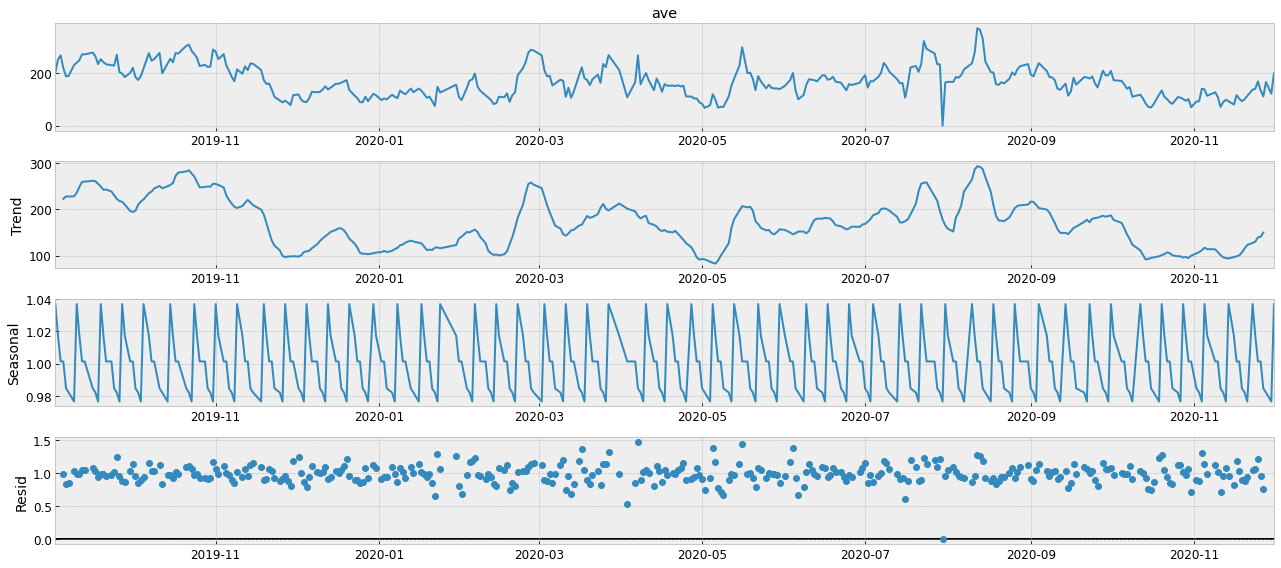

In [49]:

p_ts1 = ts[-365:].ave+ 0.01
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')

result = seasonal_decompose(p_ts1, model='multiplicative', period=7)
result.plot()
pass

<Figure size 4000x1600 with 0 Axes>

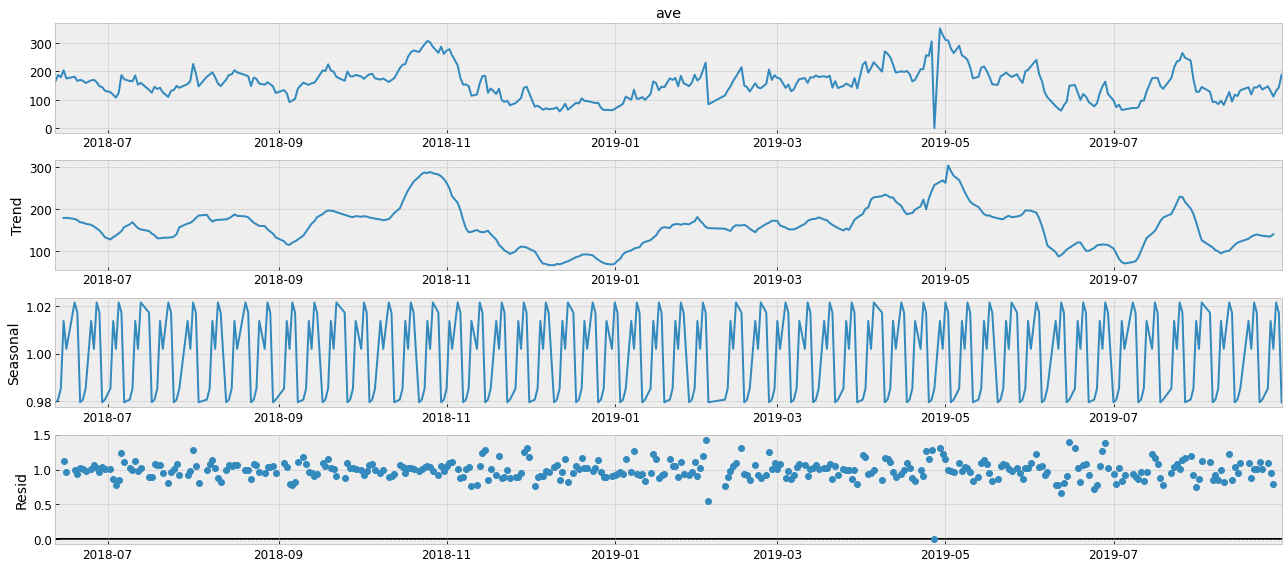

In [50]:

p_ts2 = ts[-730:-365].ave+ 0.01
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')

result = seasonal_decompose(p_ts2, model='multiplicative', period=7)
result.plot()
pass

In [51]:
#building the model
autoModel = pm.auto_arima(train.ave, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True)
fitted_model = autoModel.fit(train.ave)


# Forecasting the values.
forecast_values = fitted_model.predict(len(test.ave), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test.ave.index)

mse = ((test.ave.values - fcv_series.values) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=60747.333, Time=30.56 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=61256.334, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=61053.073, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=61006.390, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=61254.334, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=15.67 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=60746.206, Time=14.97 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=9.41 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=60747.286, Time=34.24 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=36.89 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=11.72 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=13.11 sec
 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=18.75 sec
 ARIMA(2,1,3)(1,0,0)[7] intercept   : AIC=inf, Time=15.62 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=60815.963,

In [53]:
#building the model
autoModel = pm.auto_arima(train.ave, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
fitted_model = autoModel.fit(train.ave)


# Forecasting the values.
forecast_values = fitted_model.predict(len(test.ave), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test.ave.index)

mse = ((test.ave.values - fcv_series.values) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=60736.052, Time=17.04 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=61256.334, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=61057.333, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=61013.375, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=61254.334, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=inf, Time=18.64 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=inf, Time=15.63 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=inf, Time=30.11 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=inf, Time=32.02 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=inf, Time=9.86 sec
 ARIMA(2,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=26.39 sec
 ARIMA(2,1,2)(2,0,0)[6] intercept   : AIC=inf, Time=23.61 sec
 ARIMA(2,1,2)(2,0,2)[6] intercept   : AIC=60760.412, Time=29.95 sec
 ARIMA(1,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=21.40 sec
 ARIMA(2,1,1)(1,0,1)[6] intercept   : AIC=inf, Time=15.23 

In [ ]:
#building the model
autoModel = pm.auto_arima(train.ave, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=30, stepwise=True)
fitted_model = autoModel.fit(train.ave)


# Forecasting the values.
forecast_values = fitted_model.predict(len(test.ave), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test.ave.index)

mse = ((test.ave.values - fcv_series.values) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=60749.891, Time=87.45 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=61256.334, Time=0.32 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=61058.433, Time=4.20 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=61013.442, Time=6.37 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=61254.334, Time=0.15 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=60747.983, Time=75.80 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=inf, Time=10.42 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=60757.683, Time=428.51 sec


In [ ]:
#building the model
autoModel = pm.auto_arima(train.ave, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=360, stepwise=True)
fitted_model = autoModel.fit(train.ave)


# Forecasting the values.
forecast_values = fitted_model.predict(len(test.ave), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test.ave.index)

mse = ((test.ave.values - fcv_series.values) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [52]:
mod = ARIMA(train.ave, order=(3, 1, 3))
results = mod.fit()
fc, _ ,  _ = results.forecast(14, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)

mse = ((test.ave.values - fc_series) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 29.29


In [64]:
#Prophet needs some specifics data stuff, coment it here
prophet_training = train.rename(columns={'ave': 'y'})  # old method  
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = test.rename(columns={'ave': 'y'})  # old method  
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [65]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    holidays_prior_scale=20, 
    daily_seasonality=False, 
    weekly_seasonality=False, 
    yearly_seasonality=False
    ).add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=55
    ).add_seasonality(
        name='daily',
        period=1,
        fourier_order=15
    ).add_seasonality(
        name='weekly',
        period=7,
        fourier_order=25
    ).add_seasonality(
        name='yearly',
        period=365.25,
        fourier_order=20
    ).add_seasonality(
        name='quarterly',
        period=365.25/4,
        fourier_order=55
    )

prophet.fit(prophet_training)

In [73]:
future = prophet.make_future_dataframe(periods=14) #forecasting for 1 year from now.
# 進行預測
forecast = prophet.predict(future)

yhat =  forecast.tail(14).yhat.to_numpy()

mse = ((prophet_test.y.values - np.array(yhat)) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 42.49


In [2]:
air_pollution = pd.read_csv('air_pollution.csv',parse_dates=['date'])
air_pollution.set_index('date',inplace=True)
air_pollution.head() #

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [3]:

#We split our dataset to be able to evaluate our models

resultsDict={}
predictionsDict={}

split_date ='2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1461 days of training data 
 364 days of testing data 


In [4]:
df_training

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333
...,...,...,...,...,...,...,...,...
2013-12-28,21.125000,-22.958333,-1.250000,1026.208333,78.201667,0.000000,0.0,31.916667
2013-12-29,50.520833,-22.875000,1.041667,1019.208333,12.253750,0.000000,0.0,21.125000
2013-12-30,39.833333,-22.458333,4.166667,1015.708333,57.210833,0.000000,0.0,50.520833


In [5]:
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [7]:
X_train_df

,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday,hour,dayofweek,quarter,month,year,dayofyear,sin_day,cos_day,dayofmonth,weekofyear
date,,,,,,,,,,,,,,,,,
2010-01-02,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667,0,5,1,1,2010,2,0.909297,-0.416147,2,53
2010-01-03,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333,0,6,1,1,2010,3,0.141120,-0.989992,3,53
2010-01-04,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333,0,0,1,1,2010,4,-0.756802,-0.653644,4,1
2010-01-05,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333,0,1,1,1,2010,5,-0.958924,0.283662,5,1
2010-01-06,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333,0,2,1,1,2010,6,-0.279415,0.960170,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-28,-22.958333,-1.250000,1026.208333,78.201667,0.000000,0.0,31.916667,0,5,4,12,2013,362,-0.657009,-0.753882,28,52
2013-12-29,-22.875000,1.041667,1019.208333,12.253750,0.000000,0.0,21.125000,0,6,4,12,2013,363,-0.989354,0.145530,29,52
2013-12-30,-22.458333,4.166667,1015.708333,57.210833,0.000000,0.0,50.520833,0,0,4,12,2013,364,-0.412091,0.911143,30,1


In [8]:
y_train

date
2010-01-02    145.958333
2010-01-03     78.833333
2010-01-04     31.333333
2010-01-05     42.458333
2010-01-06     56.416667
                 ...    
2013-12-28     21.125000
2013-12-29     50.520833
2013-12-30     39.833333
2013-12-31     51.833333
2014-01-01     53.416667
Name: pollution_today, Length: 1461, dtype: float64

In [6]:
X_train_df, y_train = create_time_features(df_training, target='pollution_today')
X_test_df, y_test = create_time_features(df_test, target='pollution_today')
# scaler = StandardScaler() 
# scaler.fit(X_train_df) #No cheating, never scale on the training+test!
# X_train = scaler.transform(X_train_df)  
# X_test = scaler.transform(X_test_df)

# X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
# X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

In [218]:
ts

,highest,high,mid,low,ave,volume
date,,,,,,
1998-12-01,195,131,77,59,84.0,327
1998-12-02,165,144,111,93,113.0,456
1998-12-03,204,160,82,65,94.0,432
1998-12-04,189,161,114,80,116.0,583
1998-12-06,181,157,90,55,96.0,1052
...,...,...,...,...,...,...
2020-11-26,201,201,137,67,134.9,97
2020-11-27,170,170,112,52,111.8,176
2020-11-28,171,171,170,152,166.7,81


In [217]:
import pandas as pd
from datetime import datetime

datelist = pd.date_range(ts.index[0], periods=ts.shape[0]).tolist()
ts.index = datelist

In [219]:
ts.index = datelist

In [220]:
ts

,highest,high,mid,low,ave,volume
1998-12-01,195,131,77,59,84.0,327
1998-12-02,165,144,111,93,113.0,456
1998-12-03,204,160,82,65,94.0,432
1998-12-04,189,161,114,80,116.0,583
1998-12-05,181,157,90,55,96.0,1052
...,...,...,...,...,...,...
2017-02-03,201,201,137,67,134.9,97
2017-02-04,170,170,112,52,111.8,176
2017-02-05,171,171,170,152,166.7,81
2017-02-06,172,171,119,82,122.4,88
